Download do Cassandra: http://downloads.datastax.com/community

Após instalar, executar o Cassandra CQL Shell

#### Comandos

- describe keyspace: Lista os schemas criados no BD

##### Criação de KEYSPACE

In [5]:
#CREATE KEYSPACE <Name> WITH REPLICATION = {'class':'SimpleStrategy','replication_factor':'3'};

#-> Leva consideração conforme topologia do BD SimpleStrategy
#-> Fator de replicação para replicar aos cluster

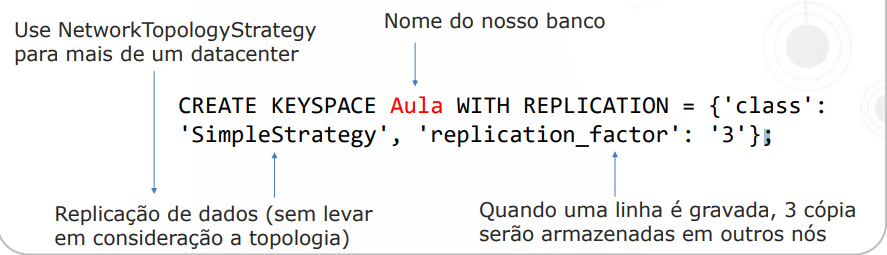

In [ ]:
# use <db_name>  -> Acessa o BD

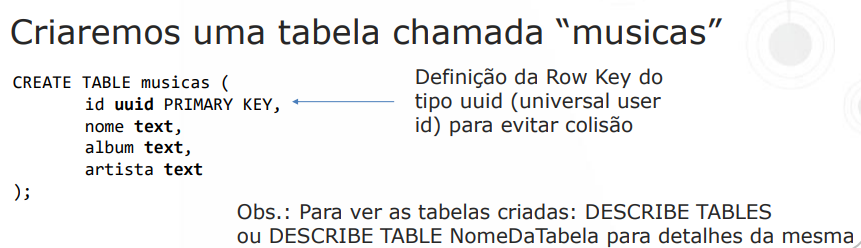

In [ ]:
#describe tables

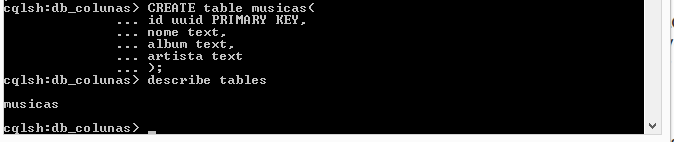

In [1]:
#use <DB Name>

In [2]:
#describe tables

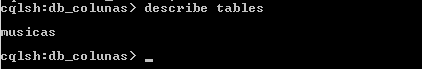

In [ ]:
#descibe table musicas

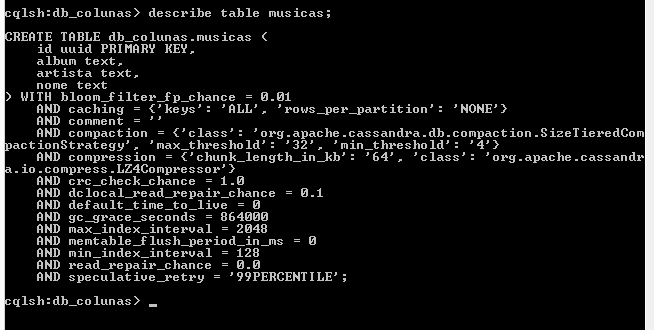

In [ ]:
#INSERT

#INSERT INTO musicas (id, nome, album, artista)
#VALUES (uuid(), 'Help', 'Help', 'Beatles');

#uuid() -> Função que gera um ID Uníco no BD cassandra

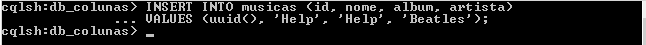

In [ ]:
#UPDATE

# UPDATE musicas SET nome = 'Help!', album = 'Help!' WHERE id = ad2fe06d-6483-4446-b7b4-c6060a5bf204;

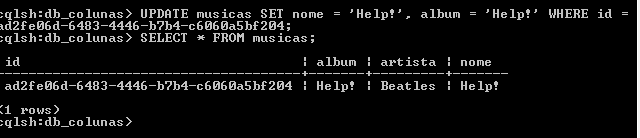

In [ ]:
#DELETE FROM musicas WHERE id = ad2fe06d-6483-4446-b7b4-c6060a5bf204;

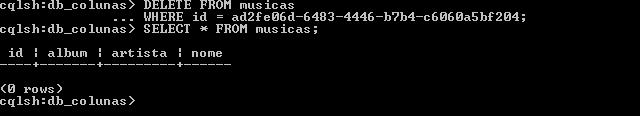

<b>Registros temporários

In [ ]:
#INSERT INTO musicas (id, nome, album, artista) VALUES (UUID(),'The Nigth Before','Help!','Beatles') 

O uso do TTL (Time To Live) é adequado para funcionalidades para expirar por tempo de uso. Revogar acesso de usuário ou expirar o tempo de uma propaganda (banner) no site, por exemplo.

Se não for especificado, o valor default é nunca expirar

SELECT *
FROM musicas
WHERE artista='Beatles'; 

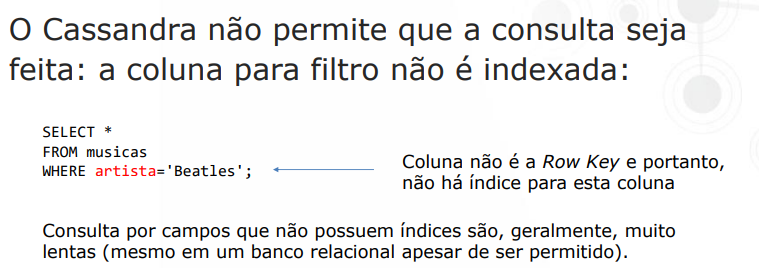

Erro: InvalidRequest: Error from server: code=2200 [Invalid query] message="Cannot exe
cute this query as it might involve data filtering and thus may have unpredictab
le performance. If you want to execute this query despite the performance unpred
ictability, use ALLOW FILTERING"

In [ ]:
#ALLOW FILTERING

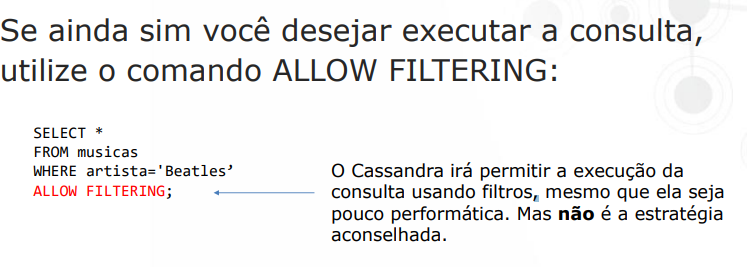

#### Indices

Um índice é geralmente uma estrutura em árvore ou hash que acelera a consulta em um banco.

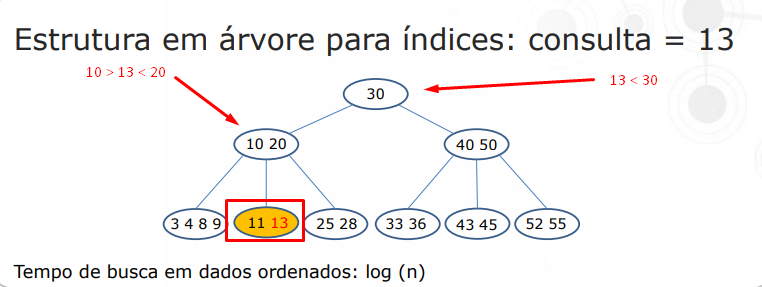

O índice evita que todos as linhas sejam consultadas para atender ao filtro especificado na consulta.
Para melhorar, podemos criar índices dos campos em cada tabela (o campo Row Key contém índice criado pelo próprio Cassandra). 

In [5]:
#Criar um índice
#CREATE INDEX ON musicas (artista);
# Ou CREATE INDEX nome_do_indice ON musicas (artista);

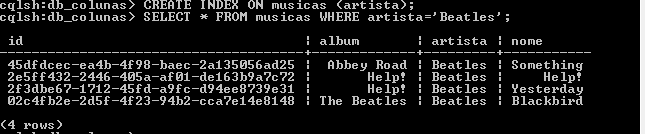

In [ ]:
#DROP INDEX IF EXIST <musicas_artista_idx> <<< Deafult

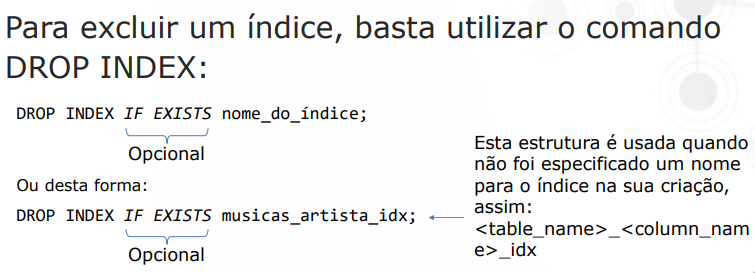

Não recomenda-se a utilização de indice quando a coluna sofre muitas alterações (UPDATES etc.)

- Evite criar índices em colunas que podem sofrer muitas alterações (acessar índice é rápido, mas criar e modificar pode ser muito lento).
- Evite criar índices em colunas com alta cardinalidade (coluna com vários valores). Ex.: ao buscar uma músicas pode ser mais eficiente consultas por “artistas” do que por “compositor”.

#### Playlist

In [8]:
'''
CREATE TABLE playlist_atual (
id_playlist int,
posicao int,
id_musica uuid,
nome text, << Coluna redundante
album text, << Coluna redundante
artista text, << Coluna redundante
PRIMARY KEY (id_playlist, posicao)
);

Para o BD NoSQL essa redundância não é um problema
'''

'\nCREATE TABLE playlist_atual (\nid_playlist int,\nposicao int,\nid_musica uuid,\nnome text, << Coluna redundante\nalbum text, << Coluna redundante\nartista text, << Coluna redundante\nPRIMARY KEY (id_playlist, posicao)\n);\n\nPara o BD NoSQL essa redundância não é um problema\n'

<b>Joins</b>

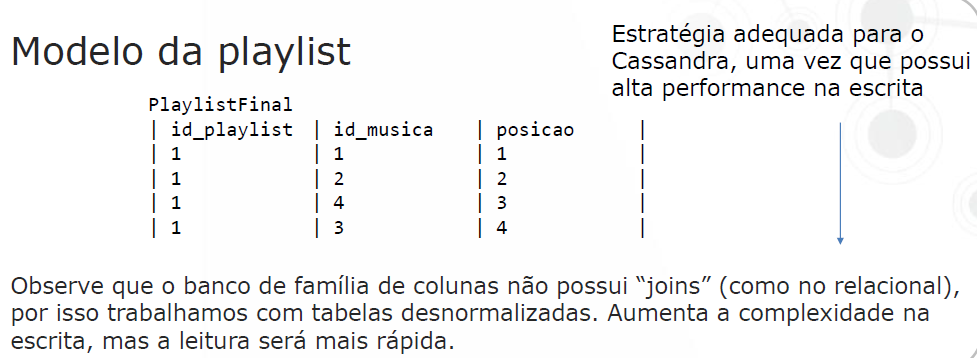

O modelo de dados mais amplamente utilizado em bancos colunares são chamados “dynamic columns”.

Estas tabelas não possuem colunas predefinidas.

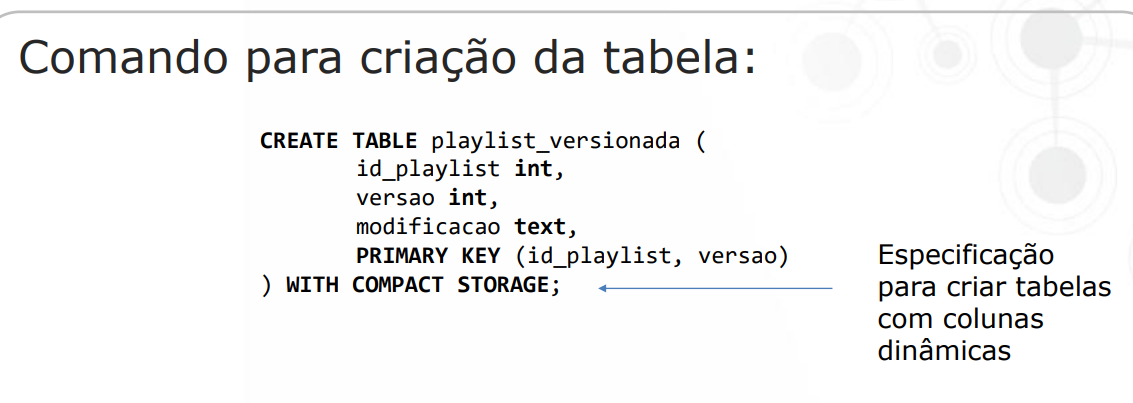

In [ ]:
'''
CREATE TABLE playlist_versionada (
id_playlist int,
versao int,
modificacao text,
PRIMARY KEY (id_playlist, versao)
) WITH COMPACT STORAGE;  << indica tabela dinamica

DESCRIBE TABLES;
'''

##### INSERT

INSERT INTO playlist_versionada (id_playlist, versao, modificacao)
VALUES (1, 1, 'ADI(Help!)');

INSERT INTO playlist_versionada (id_playlist, versao, modificacao)
VALUES (1, 2, 'ADI(Yesterday)');


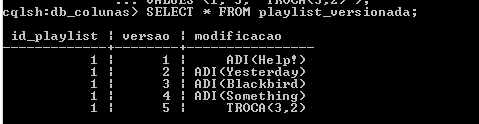

##### Como é armazenado

Este modelo é utilizado devido a quantidade de escrita e pesquisa

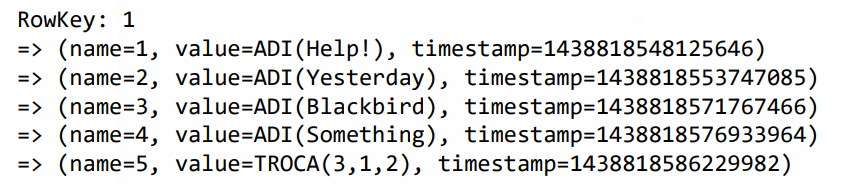

#### Cassandra Driver para Python 

In [11]:
from cassandra.cluster import Cluster
cluster = Cluster()
session = cluster.connect('db_colunas')

'''
session.execute ("""
CREATE TABLE users (
id uuid PRIMARY KEY,
lastname text,
age text,
city text,
email text,
firstname text
);
""")
'''

'\nsession.execute ("""\nCREATE TABLE users (\nid uuid PRIMARY KEY,\nlastname text,\nage text,\ncity text,\nemail text,\nfirstname text\n);\n""")\n'

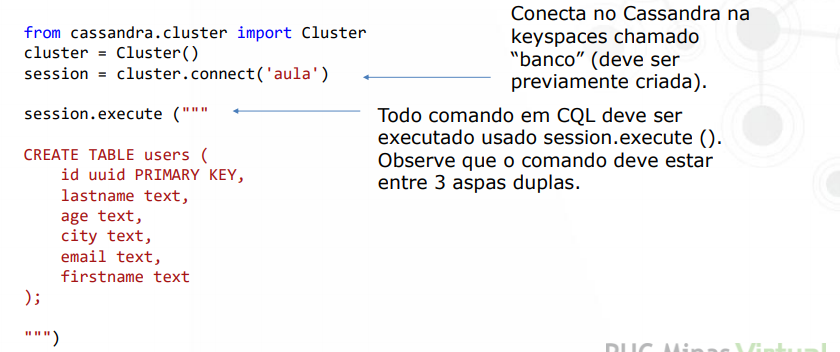

In [13]:
session.execute("""
insert into users (id, lastname, age, city,
email, firstname) values (uuid(), 'Jones',
'35', 'Austin', 'bob@example.com', 'Bob')
""")

result = session.execute("select * from users where lastname='Jones' ALLOW FILTERING; ")[0]
print (result.age, result.lastname)

35 Jones


In [17]:
result = session.execute("""
select * from users where 
lastname='Jones' ALLOW FILTERING; """)[0] #primeira linha
print (result.age, result.lastname)

result = session.execute("""
select * from users where 
lastname='Jones' ALLOW FILTERING; """) #primeira linha
print (result)

35 Jones


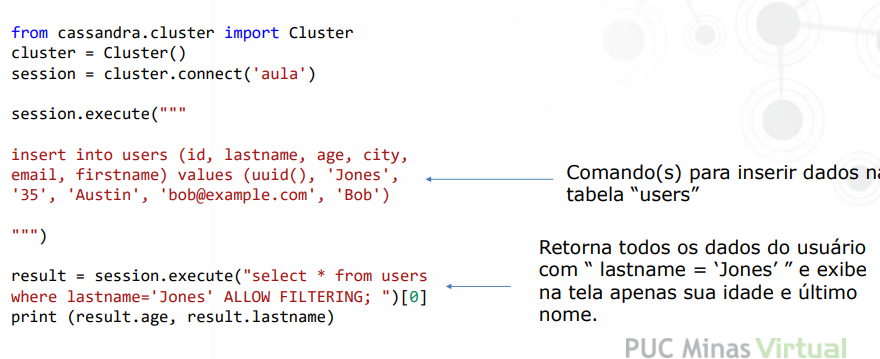

In [23]:
session.execute("""
insert into users (id, lastname, age, city,
email, firstname) values (uuid(), 'Melo',
'25', 'São Paulo', 'clmo@example.com', 'Camila')
""")

In [31]:
result = session.execute("""
select * from users ALLOW FILTERING; 
""") #primeira linha

for i in result:
    print(i.lastname,',',i.firstname)

Melo , Camila
Melo , Camila
Jones , Bob
Melo , Camila
Melo , Camila
Melo , Camila
Melo , Camila


In [52]:
result = session.execute("""
select * from playlist_versionada; 
""") #primeira linha

for i in result:
    print(i.id_playlist,',',i.versao, i.modificacao)
    if ('ADI') in i.modificacao:
        print('Yes')
    if ('TROCA') in i.modificacao:
        print('Yes1')

1 , 1 ADI(Help!)
Yes
1 , 2 ADI(Yesterday)
Yes
1 , 3 ADI(Blackbird)
Yes
1 , 4 ADI(Something)
Yes
1 , 5 TROCA(3,2)
Yes1


#### Quando usar ou não usar banco colunar

- Registro de eventos (Logs), uma outra alternativa além de ser rápido é que este BD pode atender a várias aplicações da empresa para o mesmo fim
-  Controle de tempo de acesso (expiração)

#### Quando NÃO usar
- Funções de agregação (soma, média etc.)
- Quando o tipo de consulta ainda não esta definido no projeto (Ou seja para projetos mais maduros ou migração)